# Final Project
## Kaylah Thomas and Sruti Kanthan

# Summary of notebook:


- Cleaned/merged micheiln and all-menus data (merged menu item and description data from all-menus to the Michelin data)
- Cleaned the NYPL data (historical menu database) and (newly merged) Michelin data. Prepped data for word2vec analysis by tokenizing, removing stopwords, and removing punctuation. 
- Found the tokens that both datasets shared for their menu item descriptions. Ran word2vec to find the words that were most similar to these shared words, and recorded the shared words that both datasets had in common. Also recorded the frequencies of the tokens (shared and general) for the menu descriptions for both datasets.
- Used SentenceBERT to calculate sentence similarity (pairwise) for all sentences across both databases (not within). Used the top 300 similar pairs and isolated the sentences that came from the NYPL data. We figured that the dish descriptions within the NYPL data that were the most similar to sentences within the Michelin description data could be operationalized as the 'fanciest', since Michelin has long been considered the bar to reach for fine dining. 
- Hypothesized that restaurants with higher price points (i.e., fancy) would be associated with longer dish descriptions. However, there didn't seem to be a correlation.

In [1]:
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn as sns #Makes the graphics look nicer
import spacy
import wordcloud
import nltk
import unicodedata
import requests
from bs4 import BeautifulSoup
import json
import string
from gensim import corpora, models
from sklearn.manifold import TSNE
import folium
import time

### Scraping allmenus data for michelin restaurants not covered in the Kaggle data

In [2]:
# Scraping menu data for michelin restaurants in NYC (menu items, descriptions, restaurant name, url);
# the kaggle dataset doesn't provide this, so I will merge this data with the kaggle data for analysis

nlp = spacy.load("en_core_web_sm")

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

def get_menu_data_from_link(rname, url):
#     rname = url_dict.keys()
#     url = url_dict.values()
    html = requests.get(url)
    # Use BeautifulSoup to parse the text as an HTML, so that we can select the elements we want to 
    soup = BeautifulSoup(html.text, "html.parser")
    restaurant_data = soup.find('script', type='application/ld+json')
    # set strict to False, so that control characters like \n are allowed within the text:
    info = {}
    for line in restaurant_data:
        info.update(json.loads(line, strict=False))
    
    nested_items = []
    for section in info['hasMenu'][0]['hasMenuSection']:
        if 'hasMenuItem' not in section.keys():
            pass
        else:
            nested_items.extend([section['hasMenuItem']])
    name = [j['name'] for i in nested_items for j in i]
    description = [j['description'] for i in nested_items for j in i]
    
    menu_data = {'Restaurant name': rname,
                 'Menu Items': name,
                 'Item Descriptions': description,
                 'URL': url}
    
    return menu_data


/Users/srutikanthan/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
michelin_nonan = pd.read_csv('michelin_nonan.csv', index_col = [0])

## Text cleaning: NYPL Data

* Loading in all NYPL provided datasets. After examination, the appropriate IDs will be merged to create one comprehensive dataframe

In [ ]:
# Defining Functions
from nltk import WordPunctTokenizer, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn, stopwords

stopwords = stopwords.words('english')

def count_tokens(tokens):
    '''
    Counts each distinct token (entity) in a list of tokens
    Inputs:
        tokens: list of tokens (must be immutable)
    Returns: dictionary that maps tokens to counts
    '''
    count_freq = {}

    for el in tokens:
    # Check if element is already in the dict
        if el in count_freq:
        # If it already is, add 1 to count
            count_freq[el] += 1
        else:
        # If it isn't, add one; also initializes key
            count_freq[el] = 1

    return count_freq



    return sub_keys

spec_chars = ['"',"#","%","&","'","(",")",
              "*","+",",","-","/",":",";","<",
              "=",">","@","[","\\","]","^","_",
              "`","{","|","}","~","–", '.', '!', "?"]

def text_clean(df):
    '''
    Cleans the description data more thoroughly, getting rid of strange characters etc.
    '''
    df['clean_text'] = df['cleaned_text'].str.strip('\n\n')
    df['clean_text'] = df['clean_text'].apply(lambda text: unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii'))
    df['clean_text'] = df['clean_text'].str.replace('\d+', '')
    
    #print(df["clean_no_sw"].to_list())
    # join the tokens back and then remove the punct?

    for char in spec_chars:
        df['clean_text'] = df['clean_text'].str.replace(char, '')

    doc_df = list(set(df['clean_text'].to_list()))
    
    doc_df = [string.strip() for string in doc_df] 
    doc_df = [x.strip(' ') for x in doc_df]
        
    return df, doc_df

def remove_stopwords(tokens):
    filtered_words = [word for word in tokens if word not in stopwords]
    return filtered_words

# need to rename this function; it initially counted adjectives in dish descriptions,
# which might be a useful indicator, but the tagger performed poorly, so this just
# provides the number of words in each dish description (as a new col)
def desc_len_count(df):
    df['tokenized_desc'] = df['dish_name'].apply(lambda x: [item for item in x.split()])
    df["no_stopwords"] = df["tokenized_desc"].apply(remove_stopwords)
    df['pos_desc'] = df['no_stopwords'].apply(nltk.tag.pos_tag)
    for row in df.itertuples():
        df.at[row.Index, 'desc_len'] = len(df['no_stopwords'].loc[row.Index])

    return df

def adj_count(x):
    adj_count = sum(1 for word, pos in pos_tag(word_tokenize(x)) if pos.startswith('NN'))
    return nounCount

In [18]:
dish = pd.read_csv('2021_05_16_07_01_22_data/Dish.csv')
dish = dish.sort_values(by='menus_appeared', ascending=False)
dish = dish.reset_index()
del dish['index']
dish = dish.rename(columns={'id': 'dish_id'})
dish = dish.rename(columns={'name': 'dish_name'})

In [19]:
dish.head(10)

,dish_id,dish_name,description,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price
0,96,Coffee,NaN,7751,8498,1,2928,0.0,30.0
1,1177,Olives,NaN,4322,4555,1858,1980,0.0,35.0
2,15,Celery,NaN,4248,4693,1,2928,0.0,50.0
3,97,Tea,NaN,4167,4781,1858,2012,0.0,25.0
4,7,Radishes,NaN,3262,3346,1854,2928,0.0,25.0
5,83,Mashed potatoes,NaN,2573,2660,1852,2012,0.0,15.0
6,219,Boiled potatoes,NaN,2063,2118,1858,1974,0.0,20.0
7,112,Fruit,NaN,1917,2003,1854,2928,0.0,40.0
8,98,Milk,NaN,1896,2293,1890,2012,0.0,45.0
9,217,Chicken salad,NaN,1807,1877,1858,1987,0.0,100.0


In [20]:
# renaming id columns for easier readability
menu = pd.read_csv('2021_05_16_07_01_22_data/Menu.csv') 
menu = menu.rename(columns={'id': 'menu_id'})

In [21]:
menu_item = pd.read_csv('2021_05_16_07_01_22_data/MenuItem.csv')
menu_item = menu_item.rename(columns={'id': 'menu_item_id'})

In [22]:
menu_page = pd.read_csv('2021_05_16_07_01_22_data/MenuPage.csv')
menu_page = menu_page.rename(columns={'id': 'menu_page_id'})

In [23]:
# prelimnary data analysis, merging all datasets on menu ids for ease of examination

merged_df = pd.merge(menu, menu_page, on="menu_id", how='inner')
merge_data = pd.merge(merged_df, menu_item, on="menu_page_id", how='inner')
all_data = pd.merge(merge_data, dish, on="dish_id", how='inner')


In [24]:
r1 = all_data[all_data['price'].notna()]
restaurants = r1[all_data['date'].notna()]



<ipython-input-24-c800773531eb>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  restaurants = r1[all_data['date'].notna()]


In [25]:
df = restaurants[['menu_id', 'place', 'occasion', 'date', 'location', 'page_count', 'dish_count',
                        'dish_name', 'dish_id', 'menu_item_id', 'menu_page_id', 'menus_appeared', 'times_appeared', 
                        'first_appeared', 'last_appeared',
       'lowest_price', 'highest_price', 'price', 'high_price']]

In [26]:
df # complete Historical Menu dataframe

,menu_id,place,occasion,date,location,page_count,dish_count,dish_name,dish_id,menu_item_id,menu_page_id,menus_appeared,times_appeared,first_appeared,last_appeared,lowest_price,highest_price,price,high_price
1,12534,PABST BLUE RIBBON,NaN,1900-03-11,Pabst Blue Ribbon,2,52,Sliced Bananas,31.0,42565,364,221,239,1900,1987,0.0,15.0,0.15,NaN
2,12545,"137 E. MADISON ST.,CHICAGO,ILL.",NaN,1900-03-30,German Restaurant & Buffet,4,113,Sliced Bananas,31.0,21187,404,221,239,1900,1987,0.0,15.0,0.15,NaN
4,12654,NaN,NaN,1900-03-11,Pabst Blue Ribbon,2,50,Sliced Bananas,31.0,173443,751,221,239,1900,1987,0.0,15.0,0.15,NaN
5,12665,NaN,NaN,1900-03-30,German Restaurant & Buffet,4,112,Sliced Bananas,31.0,7878,791,221,239,1900,1987,0.0,15.0,15.00,NaN
6,12700,"137 E. MADISON ST. CHICAGO, ILL.",DAILY,1900-03-31,German Restaurant & Buffet,4,109,Sliced Bananas,31.0,10775,894,221,239,1900,1987,0.0,15.0,0.15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329111,35518,NaN,NaN,1913-09-24,Hotel Schynige Platte und Hotel Bellevue,4,161,Omelette mit Schincken,498469.0,1366284,77373,1,1,1913,1913,1.5,1.5,1.50,NaN
1329112,35518,NaN,NaN,1913-09-24,Hotel Schynige Platte und Hotel Bellevue,4,161,Omelette mit Rhum,498470.0,1366285,77373,1,1,1913,1913,1.5,1.5,1.50,NaN
1329113,35518,NaN,NaN,1913-09-24,Hotel Schynige Platte und Hotel Bellevue,4,161,Omelette mit Confiture,498471.0,1366286,77373,1,1,1913,1913,1.5,1.5,1.50,NaN
1329114,35518,NaN,NaN,1913-09-24,Hotel Schynige Platte und Hotel Bellevue,4,161,Süsse Tagesplatten,498472.0,1366288,77373,1,1,1913,1913,1.0,1.0,1.00,NaN


* Merging and formatting complete for NYPL Historical Menu dataset. Now, cleaning text data and collecting other variables.

In [27]:
df['dish_name'] = df['dish_name'].str.lower()

<ipython-input-27-ac97e1c35e4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dish_name'] = df['dish_name'].str.lower()


In [32]:
pos_rest = desc_len_count(df) ## as mentioned in the paper, the POS tagging
# was not accurate so we dropped this part of the analysis

<ipython-input-31-7d1fbb3b5f15>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_desc'] = df['dish_name'].apply(lambda x: [item for item in x.split()])
<ipython-input-31-7d1fbb3b5f15>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["no_stopwords"] = df["tokenized_desc"].apply(remove_stopwords)
<ipython-input-31-7d1fbb3b5f15>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [33]:
for row in pos_rest.itertuples():
    pos_rest.at[row.Index, 'desc_all_len'] = len(df['tokenized_desc'].loc[row.Index])

In [34]:
pos_rest.head()

,menu_id,place,occasion,date,location,page_count,dish_count,dish_name,dish_id,menu_item_id,...,last_appeared,lowest_price,highest_price,price,high_price,tokenized_desc,no_stopwords,pos_desc,desc_len,desc_all_len
1,12534,PABST BLUE RIBBON,NaN,1900-03-11,Pabst Blue Ribbon,2,52,sliced bananas,31.0,42565,...,1987,0.0,15.0,0.15,NaN,"[sliced, bananas]","[sliced, bananas]","[(sliced, VBN), (bananas, NNS)]",2.0,2.0
2,12545,"137 E. MADISON ST.,CHICAGO,ILL.",NaN,1900-03-30,German Restaurant & Buffet,4,113,sliced bananas,31.0,21187,...,1987,0.0,15.0,0.15,NaN,"[sliced, bananas]","[sliced, bananas]","[(sliced, VBN), (bananas, NNS)]",2.0,2.0
4,12654,NaN,NaN,1900-03-11,Pabst Blue Ribbon,2,50,sliced bananas,31.0,173443,...,1987,0.0,15.0,0.15,NaN,"[sliced, bananas]","[sliced, bananas]","[(sliced, VBN), (bananas, NNS)]",2.0,2.0
5,12665,NaN,NaN,1900-03-30,German Restaurant & Buffet,4,112,sliced bananas,31.0,7878,...,1987,0.0,15.0,15.00,NaN,"[sliced, bananas]","[sliced, bananas]","[(sliced, VBN), (bananas, NNS)]",2.0,2.0
6,12700,"137 E. MADISON ST. CHICAGO, ILL.",DAILY,1900-03-31,German Restaurant & Buffet,4,109,sliced bananas,31.0,10775,...,1987,0.0,15.0,0.15,NaN,"[sliced, bananas]","[sliced, bananas]","[(sliced, VBN), (bananas, NNS)]",2.0,2.0


#### the salient price variable seems to be 'price' (not 'lowest' or 'highest price')


In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer


* Isolating all dish names into one list to begin NLP

In [36]:
dishes = list(set(pos_rest['dish_name'].to_list())) # dropping duplicates for clustering

In [37]:
dishes

["hors d'oeuvres assorted a la mouquin",
 'lebendfrische schwarzwaldbachforelle blau mit zerlassener butter und salzkartoffeln (truite au bleu)',
 'flensburger raucheraal mit butter und brot',
 'sweetbreads patties financiere',
 'sirloin steak a la minute mixed vegetables, french fried potatoes',
 'teigwaren, schinken, salat',
 'omelette mit geflugelleber und champignons',
 'fruit (per person), seedless grapes',
 'jamaica run',
 'cockburn, very old',
 "heap o'fruit plate salad",
 'g. h. mumm & co., gold seal',
 'craps',
 'entrees- rhine- glass',
 'purée of new lima beans',
 'bonded bourbons',
 'gilka kummer',
 'royal cabinet',
 'chicken consomme liquide',
 'boiled ribs of beef, menagere with cabbage, carrots, horseradish and boiled potatoes',
 'choice of (2) fried eggs with sausages or bacon or ham',
 'spanish omelet with rice',
 'beef, lettuce, pickle and tomato sandwich',
 'half squab chicken, archiduc',
 'seezungenfilets "walewska", siam-patna-reis',
 'baked sugar cured ham, fresh s

In [38]:
pos_rest["cleaned_text"] = pos_rest['no_stopwords'].apply(lambda x: "'" + "', '".join(x) + "'")

<ipython-input-38-547646a0021a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_rest["cleaned_text"] = pos_rest['no_stopwords'].apply(lambda x: "'" + "', '".join(x) + "'")


In [ ]:
nypl_df = text_clean(pos_rest)



In [ ]:
docs = nypl_df[1] 
docs

In [41]:
for string in docs:
    " ".join(string.split())
    
doc_input = [string for string in docs if string != ""]


### Prepping NYPL dish description data for word2vec model

In [44]:
import random
SEED = 42
random.seed(SEED)
from gensim.models import Word2Vec

In [ ]:
vector_nypl = [x.split() for x in doc_input]
vector_nypl

In [46]:
model_nypl = Word2Vec(sentences=vector_nypl, workers=1, 
                      seed=SEED)

### Text cleaning (Michelin)

* Word2vec for Michelin data

In [47]:
def remove_punct(column, df):
    # define punctuation
    punctuations = '''"--"!()[]{};:'"\,<>./?@#$%^&*_~%'''

    #my_str = mb['cleaned_text'][1]

    # To take input from the user
    # my_str = input("Enter a string: ")

    # remove punctuation from the string
    no_punct_col = df[column].copy() #The values in no_punct_col will be overwritten at the end of the for row loop
    i=0
    for row in df[column]: # looking at each row
        no_punct_str = ""
        for char in row:
            if char not in punctuations:
                no_punct_str = no_punct_str + char
        no_punct_col[i] = no_punct_str # overwrite value in no_punct_col
        i += 1
        

    # display the unpunctuated string
    return no_punct_col

In [85]:
# making copy to extract only desired variables
mich_data = pd.read_csv('michelin_nonan.csv')

In [86]:
mich_data = mich_data[['name', 'Menu Items', 'Item Descriptions']]
mich_data.head()

,name,Menu Items,Item Descriptions
0,Sushi Inoue,"['Soup of the Day', 'Garden Salad', 'Seaweed S...","['', '', '', '', '', '', '', '', '', '', '', '..."
1,Jean-Georges,"['Two Egg Toast, Caviar, Herbs', 'Two Egg Toas...",['1 oz of Petrossian Special JG Selection Cavi...
2,Masa,['Kegani Hairy Crab With Chrysanthemum Sunomon...,"['', '', '', '', '', '', '', '', '', '', '', '..."
3,Marea,"['South Bay Blonde', 'East Beach Blonde', 'Kum...","['massachusetts', 'rhode island', 'washington'..."
4,Daniel,"['Huitre Shigoku', 'Seriole', 'Poularde', 'Hom...",['chilled oysters &amp;quot;en gelée&amp;quot;...


In [87]:
mich_data['Item_desc_done'] = remove_punct('Item Descriptions', mich_data) # remove all punctuation
mich_data['Item_desc_done'] = mich_data['Item_desc_done'].str.replace('\d+', '') # remove numbres
mich_data['Item_desc_done'] = mich_data['Item_desc_done'].str.strip() # remove leading and trailing whitespace/escape chars
mich_data['Item_desc_done'] = mich_data['Item_desc_done'].apply(lambda text: unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii'))
mich_data['Item_desc_done'] = mich_data['Item_desc_done'].replace('\s+', ' ', regex=True)
mich_data['Item_desc_done'] = mich_data['Item_desc_done'].str.lower()

In [88]:
mich_data["Menu Items"] = mich_data["Menu Items"].astype('str')


In [89]:
mich_data["cleaned_menu"] = mich_data["Menu Items"].str.replace('[^\w\s]','')
mich_data['Menu_Items_done'] = remove_punct('cleaned_menu', mich_data) # remove all punctuation
mich_data['Menu_Items_done'] = mich_data['Menu_Items_done'].str.replace('\d+', '') # remove numbres
mich_data['Menu_Items_done'] = mich_data['Menu_Items_done'].str.strip() # remove leading and trailing whitespace/escape chars
mich_data['Menu_Items_done'] = mich_data['Menu_Items_done'].apply(lambda text: unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii'))
mich_data['Menu_Items_done'] = mich_data['Menu_Items_done'].replace('\s+', ' ', regex=True)
mich_data['Menu_Items_done'] = mich_data['Menu_Items_done'].str.lower()

In [90]:
mich_data['cleaned_text'] = mich_data['Menu_Items_done'] + mich_data['Item_desc_done'] 

In [91]:
mich_data.head()

,name,Menu Items,Item Descriptions,Item_desc_done,cleaned_menu,Menu_Items_done,cleaned_text
0,Sushi Inoue,"['Soup of the Day', 'Garden Salad', 'Seaweed S...","['', '', '', '', '', '', '', '', '', '', '', '...",lean tuna analog and cucumber chopped fatty tu...,Soup of the Day Garden Salad Seaweed Salad Sea...,soup of the day garden salad seaweed salad sea...,soup of the day garden salad seaweed salad sea...
1,Jean-Georges,"['Two Egg Toast, Caviar, Herbs', 'Two Egg Toas...",['1 oz of Petrossian Special JG Selection Cavi...,oz of petrossian special jg selection caviar o...,Two Egg Toast Caviar Herbs Two Egg Toast Cavia...,two egg toast caviar herbs two egg toast cavia...,two egg toast caviar herbs two egg toast cavia...
2,Masa,['Kegani Hairy Crab With Chrysanthemum Sunomon...,"['', '', '', '', '', '', '', '', '', '', '', '...",wasabicress ampamp chikuwa with wasabi dressin...,Kegani Hairy Crab With Chrysanthemum Sunomono ...,kegani hairy crab with chrysanthemum sunomono ...,kegani hairy crab with chrysanthemum sunomono ...
3,Marea,"['South Bay Blonde', 'East Beach Blonde', 'Kum...","['massachusetts', 'rhode island', 'washington'...",massachusetts rhode island washington new york...,South Bay Blonde East Beach Blonde Kumamoto To...,south bay blonde east beach blonde kumamoto to...,south bay blonde east beach blonde kumamoto to...
4,Daniel,"['Huitre Shigoku', 'Seriole', 'Poularde', 'Hom...",['chilled oysters &amp;quot;en gelée&amp;quot;...,chilled oysters ampquoten geleeampquot fennel ...,Huitre Shigoku Seriole Poularde Homard Topinam...,huitre shigoku seriole poularde homard topinam...,huitre shigoku seriole poularde homard topinam...


In [ ]:
mich_clean =  text_clean(mich_data)
mich_clean[1]

In [ ]:
import regex as re

cleaned_mich = [sub.replace('ampcomma', '') for sub in mich_clean[1]]
cleaned_mich = [sub.replace('ampamp', '') for sub in cleaned_mich]
cleaned_mich = [sub.replace('comma', '') for sub in cleaned_mich]
cleaned_mich = [sub.replace('ampcomma', '') for sub in cleaned_mich]
cleaned_mich = [sub.replace('ampaposs', '') for sub in cleaned_mich]
cleaned_mich = [sub.replace('dobleampquot', '') for sub in cleaned_mich]
cleaned_mich = [sub.replace('ampquotpapa', '') for sub in cleaned_mich]
cleaned_mich = [sub.replace('ampquot', '') for sub in cleaned_mich]





cleaned_mich

### Prepping Michelin menu/item description data for word2vec

In [ ]:
vector_mich = [x.split() for x in cleaned_mich]
vector_mich

In [95]:
no_stop_mich = []
for l in vector_mich:
    filtered_words = [word for word in l if word not in stopwords]
    no_stop_mich.append(filtered_words)

In [ ]:
no_stop_mich

In [97]:
model_mich = Word2Vec(sentences=no_stop_mich, workers=1, 
                      seed=SEED)

* Finding most similar words from the Michelin Dataset

# Using SentenceBERT to find the most similar dish descriptions between the NYPL dish description data and Michelin description data. an ad-hoc way to isolate the "fancy" dishes in the NYPL data, if we're operationalizing 'fancy' as descriptions with a higher similarity score with those in the Michelin data

In [103]:

def compare_texts(sentlist1, sentlist2):
    from sentence_transformers import SentenceTransformer, util
    model = SentenceTransformer('paraphrase-distilroberta-base-v1')

    # Two lists of sentences
    sentences1 = sentlist1 # the doc_mb sentences after being passed into the sentence transformer

    sentences2 = sentlist2 # the doc_il sentences after being passed into the sentence transformer

    #Compute embedding for both lists
    embeddings1 = model.encode(sentences1, convert_to_tensor=True)
    embeddings2 = model.encode(sentences2, convert_to_tensor=True)

    #Compute cosine-similarits
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)



    #Find the pairs with the highest cosine similarity scores
    pairs = []
    for i in range(len(sentences1)):
        for j in range(len(sentences2)):
            pairs.append({'index': [i, j], 'score': cosine_scores[i][j].item()})


    print(len(pairs))

    #Sort scores in decreasing order
    pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

    for pair in pairs[0:300]:
        i, j = pair['index']
        print("Sent1:  {} \n Sent2:  {} \n Score: {:.4f}".format(sentences1[i], sentences2[j], pair['score']))
    return [d['score'] for d in pairs]

## the top 300 most similar pairs of sentences:

In [ ]:
########### DO NOT RUN, TAKES HOURS - I SAVED THE OUTPUT AND READ IT IN BELOW ################################


compare_texts(doc_input, cleaned_mich) 
# sentence 1 = sentence from doc_input
# sentence 2 = sentence from cleaned_mich

* Results from `compare_texts` containing only sentences from NYPL (to subset the data to the 'fanciest' restaurants/most similar to Michelin descriptions):

In [98]:
fancy_nypl = pd.read_csv('restaurant.csv', header=None)
fancy_nypl # I hadn't saved the sentences into a list, so I manually put them in a csv file
# (just copy and pasted them and deleted the sentence 2 and score lines)

,0,1
0,nypl_sent,sashimi assortment thinlysliced raw fish ser...
1,nypl_sent,japan combination lunch nova scotia salmon g...
2,nypl_sent,lobster shore cup clam chowder chicken gumbo...
3,nypl_sent,broiled salmon steak lemon butter french fri...
4,nypl_sent,shore dinner tomato juice clam chowder shrim...
...,...,...
295,nypl_sent,sirloin steak one half inches thick served ...
296,nypl_sent,de luxe lobster dinner choice soup tomato ju...
297,nypl_sent,roast loin pork apple fritter assorted vege...
298,nypl_sent,american edam roquefort cheese bents crackers


In [99]:
fancy_nypl = fancy_nypl.rename(columns={0: 'sentence'})
fancy_nypl = fancy_nypl.rename(columns={1: 'description'})
fancy_nypl['description'] = fancy_nypl['description'].apply(lambda x : str(x).strip())


In [100]:
fancy_nypl_desc = fancy_nypl['description'].to_list()
fancy_nypl_desc

['sashimi assortment thinlysliced raw fish served japanese wasabi horseradish  soy sauce served choice soup sunomono rice  japanese green tea',
 'japan combination lunch nova scotia salmon grilled special teriyaki sauce   sushi served choice soup sunomono rice  japanese green tea',
 'lobster shore cup clam chowder chicken gumbo creole crabmeat cocktail tomato juice cocktail half broiled lobster drawn butter fried scallops broiled mackerel green peas au beurre shoestring potatoes sliced tomatoes coffee tea milk',
 'broiled salmon steak lemon butter french fried potatoes pickled beet egg salad served clarks freshbaked roll muffin',
 'shore dinner tomato juice clam chowder shrimp cocktail fried scallops fresh gulf shrimp filet sole fresh crab meat salad broiled lobster tail shoestring potatoes tartar sauce slaw rolls cornsticks butter  coffee',
 'fish teriyaki fresh nova scotia salmon grilled special teriyaki sauce served choice soup sunomono rice  japanese green tea',
 'parsons seafood d

## Subsetting NYPL data to include only the dish descriptions that have a high similarity score with the michelin data descriptions

In [101]:
boolean_series = pos_rest.clean_text.isin(fancy_nypl_desc)
filtered_df = pos_rest[boolean_series]
filtered_df

,menu_id,place,occasion,date,location,page_count,dish_count,dish_name,dish_id,menu_item_id,...,highest_price,price,high_price,tokenized_desc,no_stopwords,pos_desc,desc_len,desc_all_len,cleaned_text,clean_text
637991,16016,NaN,NaN,1901-08-30,Southern Pacific Company,2,57,"american, edam or roquefort cheese, with bent'...",30323.0,79398,...,0.20,0.20,NaN,"[american,, edam, or, roquefort, cheese,, with...","[american,, edam, roquefort, cheese,, bent's, ...","[(american,, NN), (edam, NN), (roquefort, NN),...",6.0,8.0,"'american,', 'edam', 'roquefort', 'cheese,', '...",american edam roquefort cheese bents crackers
865401,26689,Hana-Bishi,NaN,1970-01-01,Hana Bishi,5,97,"ishi-yaki thinly sliced choice n.y. steak, ala...",157811.0,511872,...,6.50,6.50,NaN,"[ishi-yaki, thinly, sliced, choice, n.y., stea...","[ishi-yaki, thinly, sliced, choice, n.y., stea...","[(ishi-yaki, JJ), (thinly, RB), (sliced, JJ), ...",28.0,34.0,"'ishi-yaki', 'thinly', 'sliced', 'choice', 'n....",ishiyaki thinly sliced choice ny steak alaskan...
865674,26693,The Navigator Room (Navigator Restaurant),NaN,1969-06-15,Harborside Inn,5,55,"fried seafood platter clams, scallops, swordfi...",172129.0,530043,...,5.50,5.50,NaN,"[fried, seafood, platter, clams,, scallops,, s...","[fried, seafood, platter, clams,, scallops,, s...","[(fried, VBN), (seafood, NN), (platter, NN), (...",13.0,13.0,"'fried', 'seafood', 'platter', 'clams,', 'scal...",fried seafood platter clams scallops swordfish...
869092,26710,Fiorello's,NaN,2000-11-06,Fiorello's,4,112,"roasted chilean seabass borlotti beans, pancet...",462838.0,534732,...,0.00,22.95,NaN,"[roasted, chilean, seabass, borlotti, beans,, ...","[roasted, chilean, seabass, borlotti, beans,, ...","[(roasted, VBN), (chilean, JJ), (seabass, NN),...",10.0,10.0,"'roasted', 'chilean', 'seabass', 'borlotti', '...",roasted chilean seabass borlotti beans pancett...
877229,26783,The Chronicle,NaN,1976-11-10,The Chronicle,3,57,"moller salad ~ mixed greens with tomatoes, swi...",420756.0,504381,...,5.25,5.25,NaN,"[moller, salad, ~, mixed, greens, with, tomato...","[moller, salad, ~, mixed, greens, tomatoes,, s...","[(moller, NN), (salad, NN), (~, NNP), (mixed, ...",30.0,33.0,"'moller', 'salad', '~', 'mixed', 'greens', 'to...",moller salad mixed greens tomatoes swiss chee...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108900,30944,NaN,NaN,1938-08-25,Donahoe's,2,247,"just as they fry it ""down on the farm"" -donaho...",430379.0,1157565,...,1.25,1.25,NaN,"[just, as, they, fry, it, ""down, on, the, farm...","[fry, ""down, farm"", -donahoe's, farm, style, c...","[(fry, RB), (""down, JJ), (farm"", NN), (-donaho...",94.0,155.0,"'fry', '""down', 'farm""', '-donahoe's', 'farm',...",fry down farm donahoes farm style chicken dinn...
1108906,30944,NaN,NaN,1938-08-25,Donahoe's,2,247,charcoal grilled planked steak or chicken dinn...,430396.0,882666,...,1.00,1.00,NaN,"[charcoal, grilled, planked, steak, or, chicke...","[charcoal, grilled, planked, steak, chicken, d...","[(charcoal, NN), (grilled, VBD), (planked, JJ)...",47.0,65.0,"'charcoal', 'grilled', 'planked', 'steak', 'ch...",charcoal grilled planked steak chicken dinner ...
1135298,31221,NaN,NaN,1933-03-23,Prince George Hotel,4,229,"*grilled spanish mackerel, creamed potatoes, c...",358810.0,931741,...,1.00,1.00,NaN,"[*grilled, spanish, mackerel,, creamed, potato...","[*grilled, spanish, mackerel,, creamed, potato...","[(*grilled, JJ), (spanish, JJ), (mackerel,, NN...",15.0,19.0,"'*grilled', 'spanish', 'mackerel,', 'creamed',...",grilled spanish mackerel creamed potatoes choi...
1147083,31651,NaN,NaN,1926-04-04,Hotel Woodstock,2,136,special easter dinner (pt.1): fresh fruit cock...,368497.0,969023,...,0.00,1.75,NaN,"[special, easter, dinner, (pt.1):, fresh, frui...","[special, easter, dinner, (pt.1):, fresh, frui...","[(special, JJ), (easter, NN), (dinner, NN), ((...",34.0,39.0,"'special', 'easter', 'dinner', '(pt.1):', 'fre...",special easter dinner pt fresh f

## Even within this  'fancy' subset, no correlation between length of dish description and dish price...

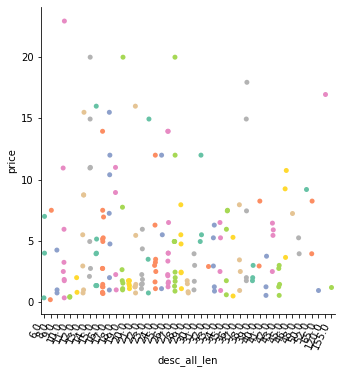

In [102]:
price_v_len = sns.catplot(x ="desc_all_len",y = "price",data = filtered_df, palette ="Set2")
price_v_len.set_xticklabels(rotation=65, 
                          horizontalalignment='right')

In [103]:
sorted_df = filtered_df.groupby(['location', 'dish_count'])['price'].max().reset_index()
sorted_df

# Price here is the max price on the menu (priciest item for that restaurant)

,location,dish_count,price
0,Alpine Room,181,5.50
1,Applebee's,116,7.29
2,Azuma Ya,123,10.95
3,Bon Vivant,208,5.45
4,Bread Market & Café,108,0.75
...,...,...,...
127,Von's Café,548,1.75
128,Waterfort,187,3.35
129,Wilder's,339,1.25
130,Yale Club Of New York,139,10.40


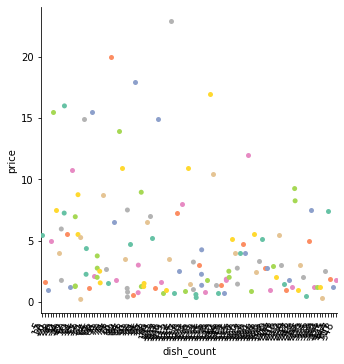

In [104]:
dish_count_price = sns.catplot(x ="dish_count",y = "price",data = sorted_df, palette ="Set2")
dish_count_price.set_xticklabels(rotation=65, 
                          horizontalalignment='right')

# not much of a relationship between the number of dishes on the menu and the max price of
# the restaurant either, even within the subset of 'fancy' restaurants! surprising 

In [112]:
pred = filtered_df[['desc_all_len', 'price']]

## Linear regression

( definitely not a linear relationship between length of dish descriptions and dish price )

In [113]:
from sklearn.linear_model import LinearRegression

In [114]:
X = pred.iloc[:, 0].values.reshape(-1, 1)  
Y = pred.iloc[:, 1].values.reshape(-1, 1)  
print(X)

[[  8.]
 [ 34.]
 [ 13.]
 [ 10.]
 [ 33.]
 [ 28.]
 [ 13.]
 [ 17.]
 [ 33.]
 [ 26.]
 [ 22.]
 [ 21.]
 [ 41.]
 [ 13.]
 [ 13.]
 [ 13.]
 [ 43.]
 [ 16.]
 [ 15.]
 [ 19.]
 [ 20.]
 [ 28.]
 [ 48.]
 [ 37.]
 [ 42.]
 [  6.]
 [ 30.]
 [ 35.]
 [ 26.]
 [ 27.]
 [ 22.]
 [ 16.]
 [ 15.]
 [ 45.]
 [ 52.]
 [ 33.]
 [ 32.]
 [ 45.]
 [ 16.]
 [ 43.]
 [ 14.]
 [ 16.]
 [ 35.]
 [ 48.]
 [ 38.]
 [ 39.]
 [ 16.]
 [ 22.]
 [ 30.]
 [ 19.]
 [ 20.]
 [ 20.]
 [ 28.]
 [ 27.]
 [ 30.]
 [ 34.]
 [ 39.]
 [ 17.]
 [ 26.]
 [ 29.]
 [ 27.]
 [ 31.]
 [ 25.]
 [ 24.]
 [ 18.]
 [ 21.]
 [ 14.]
 [ 10.]
 [ 31.]
 [ 22.]
 [ 15.]
 [ 25.]
 [ 26.]
 [ 18.]
 [  8.]
 [ 42.]
 [ 35.]
 [ 24.]
 [ 28.]
 [ 26.]
 [ 10.]
 [ 10.]
 [ 27.]
 [ 37.]
 [ 42.]
 [ 38.]
 [ 40.]
 [ 19.]
 [ 18.]
 [ 14.]
 [ 19.]
 [ 15.]
 [ 14.]
 [ 27.]
 [ 21.]
 [ 16.]
 [ 31.]
 [ 16.]
 [ 34.]
 [ 27.]
 [ 27.]
 [ 28.]
 [ 26.]
 [ 10.]
 [ 16.]
 [120.]
 [  6.]
 [ 19.]
 [ 24.]
 [ 16.]
 [ 22.]
 [ 19.]
 [ 23.]
 [ 35.]
 [ 27.]
 [ 40.]
 [ 41.]
 [ 16.]
 [ 13.]
 [ 22.]
 [ 26.]
 [  9.]
 [ 17.]
 [ 16.]
 [ 26.]


In [115]:
linear_mod = LinearRegression()  
linear_mod.fit(X, Y)  
Y_pred = linear_mod.predict(X)

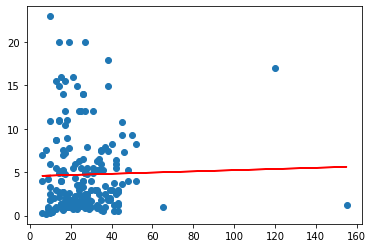

In [116]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

## Dish description token frequencies and Word2Vec

In [105]:
top10 = pd.read_csv('top10pairs.csv')
top10

,rank,nypl,michelin,cos_sim_score
0,1,sashimi assortment thinlysliced raw fish serve...,chamame white miso soup with tofu and wakam...,Score: 0.7375
1,2,japan combination lunch nova scotia salmon gri...,chamame white miso soup with tofu and wakam...,Score: 0.7350
2,3,lobster shore cup clam chowder chicken gumbo c...,east west coast oysters salmon tartar smok...,Score: 0.7297
3,4,broiled salmon steak lemon butter french fried...,water winter fruits and vegetables spanish ...,Score: 0.7245
4,5,shore dinner tomato juice clam chowder shrimp ...,east west coast oysters salmon tartar smok...,Score: 0.7235
5,6,fish teriyaki fresh nova scotia salmon grilled...,chamame white miso soup with tofu and wakam...,Score: 0.7211
6,7,parsons seafood dinner appetizer salad fried s...,sliced tomato sliced tomatoes onions luger...,Score: 0.7203
7,8,roast cornish hen brown rice stuffing bigarade...,watercress soup mushroom custard mushroom c...,Score: 0.7151
8,9,grilled smoked ham steak cherry sauce french f...,water winter fruits and vegetables spanish ...,Score: 0.7143
9,10,fried special fruit cup tomato juice soup sout...,watercress soup mushroom custard mushroom c...,Score: 0.7133


In [106]:
for i in range(len(top10)):
    print("NYPL:\n", top10['nypl'].iloc[i],"\n", "Michelin:\n", top10['michelin'].iloc[i],"\n\n")

NYPL:
 sashimi assortment thinlysliced raw fish served japanese wasabi horseradish  soy sauce served choice soup sunomono rice  japanese green tea 
 Michelin:
    chamame white miso soup with tofu and wakame salad of seasonal greens exotic japanese mushrooms en papillote yasai yonshu seaweed salad with nori dressing usuzukuri salmon hoba misoyaki assortment of salmon sashimi assortment of yellowtail sashimi trio of tartares selection of sushi selection of sashimi makimono omakase crispy seabass omakase chef omakase tasting menu anago unagi salmon scallops spicy tuna and yellowtail torotaku chutoro japanese snow crab seared japanese red snapper salmon skin tekka blue fin tuna spicy tuna hamachi yellowtail sake salmon unagi fresh water eel ebi shrimp asparagus avocado enoki mushroom takuwan ume shiso kishu plum and shiso yamaimo mountain yambrown edamame served warm with cracked sea salt with smoked sea salt and wasabi oil four vegetable hassun sashimi of fluke with ponzu and maple radis

In [107]:
prices_filt_nypl = filtered_df['price'].to_list()
print(sum(prices_filt_nypl)/len(prices_filt_nypl))

print(max(prices_filt_nypl))

4.726381909547741
22.95


In [108]:
filtered_df['tokenized_desc'] = filtered_df['dish_name'].apply(lambda x: [item for item in x.split()])
filtered_df["no_stopwords"] = filtered_df["tokenized_desc"].apply(remove_stopwords)

filtered_df["cleaned_text"] = filtered_df['no_stopwords'].apply(lambda x: "'" + "', '".join(x) + "'")


clean_filt = text_clean(filtered_df)[1]
clean_filt

<ipython-input-108-e3c5a5796580>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['tokenized_desc'] = filtered_df['dish_name'].apply(lambda x: [item for item in x.split()])
<ipython-input-108-e3c5a5796580>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["no_stopwords"] = filtered_df["tokenized_desc"].apply(remove_stopwords)
<ipython-input-108-e3c5a5796580>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

['virdan seafood platter consisting of fried shrimp deep sea scallops fillet fish sticks deviled crab cake lobster dainties sauce tartare cole slaw french fried potatoes',
 'brockles special steak dinner shrimp cocktail tomato grapefruit juice brockles special salad extra cut strip sirloin steak baked potato choice desserts coffee tea',
 'boiled beef flanken fresh horseradish matzoh ball boulangere potato vegetable salad',
 'breaded cutlets beef parmesan succulent cutlets beef dipped cracker meal fried golden brown placed casserole sherry wine parmesan cheese quickly broiled cheese melted mouthwatering dish',
 'seafood salad  shrimp scallop octopus crabstick  fish cake',
 'fried scallops beechnut bacon tartar sauce fresh carrots peas french fried potatoes',
 'broiled lamb chops served choice two potato tzimas noodle pudding hot vegetable tossed salad',
 'bouillabaisse marseillaise  epicurean delight clams lobster bass halibut salmon served chafing dish french croutons imported saffron'

In [109]:
filt_desc = []
for dish in clean_filt:
    filt_desc.append(dish.split())
filt_desc = sum(filt_desc, [])

In [110]:
count_filt_nypl = count_tokens(filt_desc)
sorted_filt_nypl = dict( sorted(count_filt_nypl.items(),
                           key=lambda item: item[1],
                           reverse=True))

sorted_filt_nypl # most frequent tokens for dish descriptions in NYPL subset

{'salad': 126,
 'fried': 86,
 'served': 67,
 'potatoes': 59,
 'french': 57,
 'sauce': 56,
 'chicken': 52,
 'fresh': 50,
 'butter': 50,
 'cheese': 45,
 'tomato': 43,
 'shrimp': 41,
 'choice': 38,
 'tea': 37,
 'dinner': 36,
 'special': 34,
 'coffee': 34,
 'green': 34,
 'cream': 34,
 'dressing': 33,
 'potato': 32,
 'broiled': 32,
 'rolls': 31,
 'fish': 29,
 'rice': 28,
 'lobster': 27,
 'bread': 27,
 'soup': 26,
 'baked': 25,
 'lettuce': 25,
 'sliced': 24,
 'steak': 23,
 'salmon': 23,
 'scallops': 22,
 'slaw': 21,
 'grilled': 21,
 'milk': 21,
 'egg': 21,
 'seafood': 20,
 'crab': 20,
 'cole': 19,
 'juice': 19,
 'beef': 19,
 'bowl': 19,
 'sour': 18,
 'vegetables': 18,
 'fruit': 18,
 'vegetable': 17,
 'tossed': 17,
 'mixed': 17,
 'crisp': 16,
 'cup': 16,
 'smoked': 16,
 'onion': 16,
 'cocktail': 15,
 'roast': 15,
 'sweet': 15,
 'topped': 15,
 'dessert': 15,
 'greens': 15,
 'clam': 15,
 'hot': 14,
 'olives': 14,
 'ham': 14,
 'brown': 13,
 'peas': 13,
 'ice': 13,
 'japanese': 13,
 'filet': 13,


In [112]:
keys_nypl = set(sorted_filt_nypl.keys())


In [111]:
no_stop_mich = sum(no_stop_mich, [])
count_filt_mich = count_tokens(no_stop_mich)
sorted_filt_mich = dict( sorted(count_filt_mich.items(),
                           key=lambda item: item[1],
                           reverse=True))
sorted_filt_mich # most frequent tokens for dish descriptions in Michelin data

{'black': 128,
 'roasted': 113,
 'salad': 105,
 'lemon': 104,
 'de': 99,
 'must': 96,
 'purchase': 96,
 'sea': 88,
 'sauce': 87,
 'red': 87,
 'salmon': 81,
 'white': 71,
 'france': 71,
 'chicken': 68,
 'tuna': 67,
 'di': 67,
 'nv': 63,
 'mushrooms': 63,
 'potato': 62,
 'lobster': 61,
 'cucumber': 59,
 'cheese': 59,
 'lime': 58,
 'cream': 58,
 'shrimp': 57,
 'green': 57,
 'grilled': 56,
 'tomato': 54,
 'fresh': 54,
 'chocolate': 53,
 'rice': 53,
 'champagne': 51,
 'avocado': 51,
 'brut': 50,
 'bass': 50,
 'butter': 50,
 'caviar': 48,
 'orange': 48,
 'egg': 48,
 'italy': 48,
 'juice': 47,
 'valley': 47,
 'sweet': 46,
 'gras': 46,
 'smoked': 46,
 'braised': 46,
 'foie': 45,
 'ale': 45,
 'truffle': 45,
 'basil': 44,
 'beef': 44,
 'new': 43,
 'celery': 43,
 'vinaigrette': 43,
 'apple': 42,
 'roll': 42,
 'fennel': 41,
 'soup': 41,
 'fried': 41,
 'blanc': 40,
 'wine': 40,
 'wild': 40,
 'duck': 39,
 'ginger': 39,
 'spicy': 39,
 'pork': 38,
 'mushroom': 37,
 'crab': 37,
 'crispy': 36,
 'lamb': 

In [113]:
keys_mich = set(sorted_filt_mich.keys())
common_terms = keys_mich.intersection(keys_nypl) # the common tokens for dish
#descriptions between both datasets


In [117]:
# Finding most similar words to each shared word in common_terms for each dataset,
# and seeing which of these similar words are shared (and counting them)

not_in_vocab = []
similar_compare = []

count = 0
for term in common_terms:
    try:
        #print("**",term,"**", "\n\n", "NYPL:", model_nypl.wv.most_similar(str(term)), "\n", "MICHELIN:", model_mich.wv.most_similar(str(term)), "\n")
        nyp_terms = model_nypl.wv.most_similar(str(term))
        mich_terms = model_mich.wv.most_similar(str(term))
        for index, word in enumerate(nyp_terms):
            for i, w in enumerate(mich_terms):
                if word[0] == w[0]:
                    count += 1
                    #print("*****", term, "*****", "Shared words:",  word[0], w[0], "*****\n\n")
                    similar_compare.append([term, "nypl:", word[0], word[1], "mich:", w[0], w[1]])

    except:
        not_in_vocab.append(term)

In [118]:
sim_df = pd.DataFrame(similar_compare)
sim_df = sim_df[[0, 2, 3, 6]]
sim_df = sim_df.rename(columns={0: 'term', 2: 'shared associated term', 3: 'nypl_simscore',6: 'mich_simscore'})
sim_df.to_csv('sim_df.csv', index=False)

In [119]:
sim_df = pd.read_csv('sim_df.csv')
sim_df # words were shared 40 times (sometimes within the same dish descriptor)

,term,shared associated term,nypl_simscore,mich_simscore
0,lamb,pork,0.606186,0.998817
1,crispy,roasted,0.732687,0.999003
2,trout,bass,0.764530,0.998888
3,grilled,roasted,0.678972,0.999170
4,pork,lamb,0.606186,0.998817
5,grapefruit,orange,0.793824,0.996600
6,bed,pasta,0.757819,0.965395
7,seafood,shrimp,0.800790,0.986099
8,orange,lime,0.753337,0.998999
9,cabbage,pickled,0.665884,0.997824
